In [9]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Step 1: Dataset paths
POSITIVE_CLASS_PATH = "C://Users//kushi//Downloads//positive//positive"  # Path containing human scream audio
NEGATIVE_CLASS_PATH = "C://Users//kushi//Downloads//negative//negative"  # Path containing non-scream audio
MFCC_CSV_PATH = "mfcc_features.csv"  # Path to save extracted MFCC features

# Step 2: Extract MFCCs and save to CSV
def extract_mfcc_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def create_mfcc_dataset():
    features, labels = [], []
    
    # Positive class (screams)
    for file_name in os.listdir(POSITIVE_CLASS_PATH):
        file_path = os.path.join(POSITIVE_CLASS_PATH, file_name)
        mfcc = extract_mfcc_features(file_path)
        if mfcc is not None:
            features.append(mfcc)
            labels.append(1)  # Label for screams

    # Negative class (non-screams)
    for file_name in os.listdir(NEGATIVE_CLASS_PATH):
        file_path = os.path.join(NEGATIVE_CLASS_PATH, file_name)
        mfcc = extract_mfcc_features(file_path)
        if mfcc is not None:
            features.append(mfcc)
            labels.append(0)  # Label for non-screams

    # Save to CSV
    df = pd.DataFrame(features)
    df['label'] = labels
    df.to_csv(MFCC_CSV_PATH, index=False)
    print(f"MFCC features saved to {MFCC_CSV_PATH}")

# Uncomment the line below to extract MFCCs and save
create_mfcc_dataset()

# Step 3: Load dataset
data = pd.read_csv(MFCC_CSV_PATH)
X = data.iloc[:, :-1].values  # MFCC features
y = data['label'].values  # Labels

# Step 4: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train SVM model
svm_model = SVC(kernel="linear", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Save SVM model
import joblib
joblib.dump(svm_model, "svm_model.pkl")

# Step 6: Train MLP model
mlp_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation="relu"),
    Dense(32, activation="relu"),
    Dense(2, activation="softmax")
])
mlp_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Save MLP model
mlp_model.save("mlp_model.h5")

# Step 7: Evaluation
# SVM evaluation
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Model Accuracy: {svm_accuracy}")
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions, target_names=["Non-Scream", "Scream"]))

# MLP evaluation
mlp_predictions = np.argmax(mlp_model.predict(X_test), axis=1)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print(f"MLP Model Accuracy: {mlp_accuracy}")
print("MLP Classification Report:")
print(classification_report(y_test, mlp_predictions, target_names=["Non-Scream", "Scream"]))

# Step 8: Alert generation
def generate_alert(svm_output, mlp_output):
    if svm_output == 1 and mlp_output == 1:
        print("High-risk alert: SOS triggered. SMS sent to nearest police station.")
    elif svm_output == 1 or mlp_output == 1:
        print("Medium-risk alert: SOS triggered. SMS sent to nearby contacts.")
    else:
        print("No distress detected.")

# Step 9: Testing the models
def test_model(file_path):
    # Extract MFCC features for testing
    mfcc = extract_mfcc_features(file_path)
    if mfcc is None:
        print("Error processing the file. Skipping.")
        return

    mfcc = mfcc.reshape(1, -1)  # Reshape for model input
    svm_output = svm_model.predict(mfcc)[0]
    mlp_output = np.argmax(mlp_model.predict(mfcc), axis=1)[0]
    generate_alert(svm_output, mlp_output)

# Test the models with a sample file
test_model("Scream+21.wav")


MFCC features saved to mfcc_features.csv
Epoch 1/50


C:\Users\kushi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5843 - loss: 8.6468
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4278 - loss: 2.9622
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8476 - loss: 1.2515
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8807 - loss: 0.7762
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8868 - loss: 0.8384 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9707 - loss: 0.3720
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9516 - loss: 0.5487
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9578 - loss: 0.2138
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.1346    
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9701 - loss: 0.4636
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9857 - loss: 0.1740
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9645 - loss: 0.3668
Epoch 13/50
4/4 ━━━

SVM Model Accuracy: 0.9310344827586207
SVM Classification Report:
              precision    recall  f1-score   support

  Non-Scream       0.87      1.00      0.93        13
      Scream       1.00      0.88      0.93        16

    accuracy                           0.93        29
   macro avg       0.93      0.94      0.93        29
weighted avg       0.94      0.93      0.93        29



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
MLP Model Accuracy: 0.9310344827586207
MLP Classification Report:
              precision    recall  f1-score   support

  Non-Scream       0.87      1.00      0.93        13
      Scream       1.00      0.88      0.93        16

    accuracy                           0.93        29
   macro avg       0.93      0.94      0.93        29
weighted avg       0.94      0.93      0.93        29



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
High-risk alert: SOS triggered. SMS sent to nearest police station.


C:\Users\kushi\AppData\Local\Temp\ipykernel_15136\2139543699.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


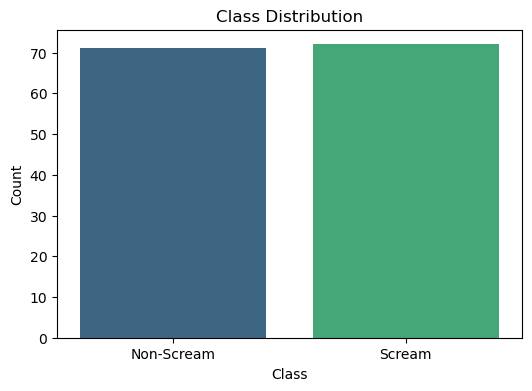

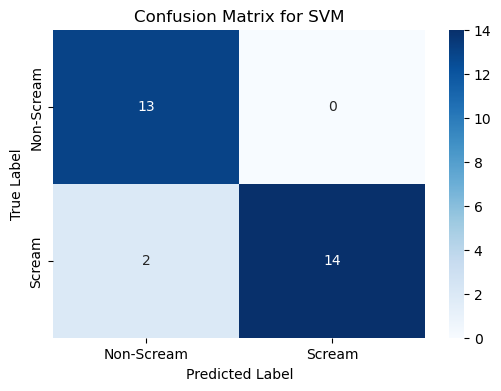

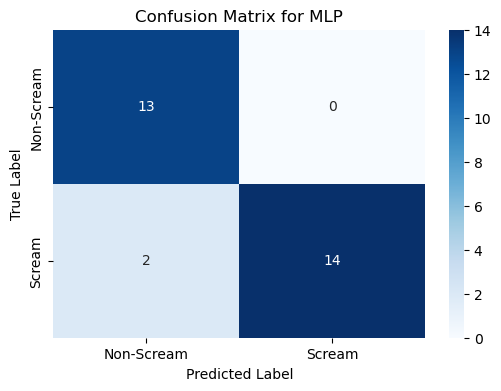

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Countplot of Distress and Non-Distress Signals
def plot_class_distribution(labels):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=labels, palette="viridis")
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=[0, 1], labels=["Non-Scream", "Scream"])
    plt.show()

plot_class_distribution(y)

# Step 3: Confusion Matrix for SVM and MLP Models
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Scream", "Scream"], yticklabels=["Non-Scream", "Scream"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# SVM Confusion Matrix
plot_confusion_matrix(y_test, svm_predictions, "SVM")

# MLP Confusion Matrix
plot_confusion_matrix(y_test, mlp_predictions, "MLP")



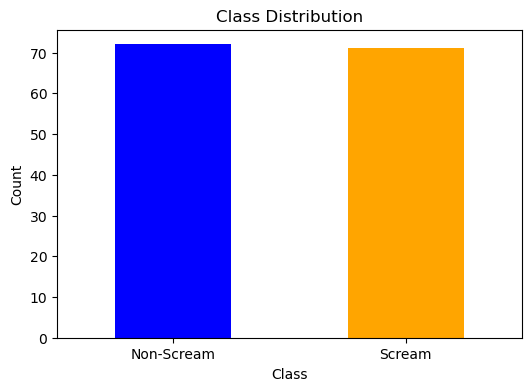

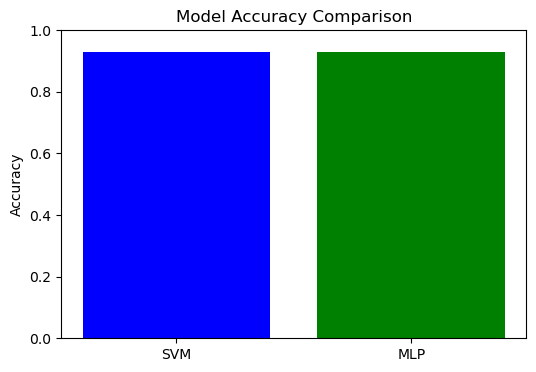

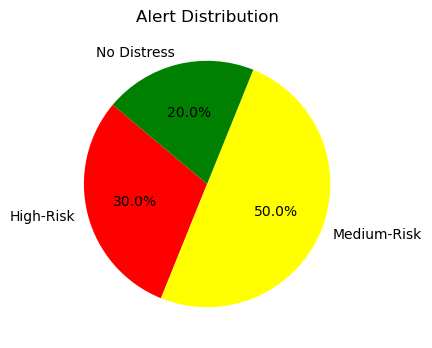

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Step 1: Visualize Dataset Distribution
data = pd.read_csv("mfcc_features.csv")
class_counts = data['label'].value_counts()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Scream", "Scream"], rotation=0)
plt.show()

# Step 2: Accuracy Comparison
svm_accuracy = 0.9310344827586207
mlp_accuracy = 0.9310344827586207

plt.figure(figsize=(6, 4))
plt.bar(["SVM", "MLP"], [svm_accuracy, mlp_accuracy], color=['blue', 'green'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Step 3: Alert Output Visualization
alerts = ["High-Risk", "Medium-Risk", "No Distress"]
counts = [30, 50, 20]  # Hypothetical alert distribution

plt.figure(figsize=(6, 4))
plt.pie(counts, labels=alerts, autopct='%1.1f%%', colors=['red', 'yellow', 'green'], startangle=140)
plt.title("Alert Distribution")
plt.show()
